<a href="https://colab.research.google.com/github/Gainward777/3D-Unet-Segmentation/blob/main/3D_Unet_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3D-Unet Sandstone Segmantation (Keras)

In [1]:
#@title Load libs
#load patchify to break large volumes into smaller for training 
!pip install patchify

from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import load_model
import random
from keras.metrics import MeanIoU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Create Model

In [17]:
#@title Loss and metric
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [18]:
#@title Create model class
class Unet3D():

  def __init__(self, input_shape, n_classes, start_filters, kernel):
      self.input_shape=input_shape
      self.n_classes=n_classes
      self.start_filters=start_filters
      self.kernel=kernel

  def build_model(self):

      def conv(input, num_filters, kernel):
          x = Conv3D(num_filters, kernel, padding="same")(input)
          x = BatchNormalization()(x)   #Not in the original network. 
          x = Activation("relu")(x)

          x = Conv3D(num_filters, kernel, padding="same")(x)
          x = BatchNormalization()(x)  #Not in the original network
          x = Activation("relu")(x)

          return x

      def encoder(input, num_filters, kernel):
          x = conv(input, num_filters, kernel)
          p = MaxPooling3D((2, 2, 2))(x)
          return x, p

      def decoder(input, skip_features, num_filters, kernel):
          x = Conv3DTranspose(num_filters, (2, 2, 2), strides=2, padding="same")(input)
          x = Concatenate()([x, skip_features])
          x = conv(x, num_filters, kernel)
          return x


      inputs = Input(self.input_shape)

      filters=self.start_filters

      first_skip, out = encoder(inputs, self.start_filters, self.kernel)
      second_skip, out = encoder(out, self.start_filters*2, self.kernel)
      third_skip, out = encoder(out, self.start_filters*4, self.kernel)
      fourth_skip, out = encoder(out, self.start_filters*8, self.kernel)

      out = conv(out, self.start_filters*16, self.kernel) #Bridge

      out = decoder(out, fourth_skip, self.start_filters*8, self.kernel)
      out = decoder(out, third_skip, self.start_filters*4, self.kernel)
      out = decoder(out, second_skip, self.start_filters*2, self.kernel)
      out = decoder(out, first_skip, self.start_filters, self.kernel)

      if self.n_classes == 1:  #Binary
        activation = 'sigmoid'
      else:
        activation = 'softmax'

      out = Conv3D(self.n_classes, 1, padding="same", activation=activation)(out)  
      print(activation)

      model = Model(inputs, out, name="U-Net")
      return model  

In [19]:
#@title Load lodel and check GPU
model = Unet3D((64,64,64,3), n_classes=4, start_filters=64, kernel=3)
model=model.build_model()
model.compile(optimizer = Adam(0.0001), loss=dice_coefficient_loss, metrics=dice_coefficient)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

softmax
Found GPU at: /device:GPU:0


##Load data

In [5]:
#@title Load input images and masks. 
#break it from 256x256x256 to 64x64x64 for training. 
image = io.imread('/content/drive/MyDrive/sandstone_data_for_ML/data_for_3D_Unet/train_images_256_256_256.tif')
img_patches = patchify(image, (64, 64, 64), step=64)  

mask = io.imread('/content/drive/MyDrive/sandstone_data_for_ML/data_for_3D_Unet/train_masks_256_256_256.tif')
mask_patches = patchify(mask, (64, 64, 64), step=64)  

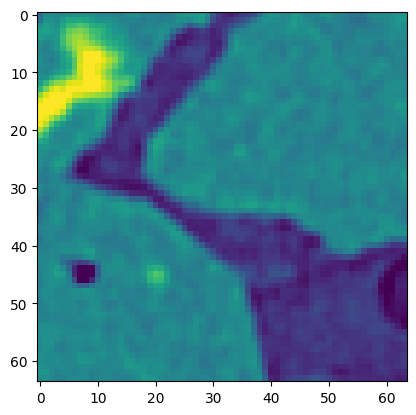

In [6]:
#@title Look at img
plt.imshow(img_patches[1,2,3,:,:,32])

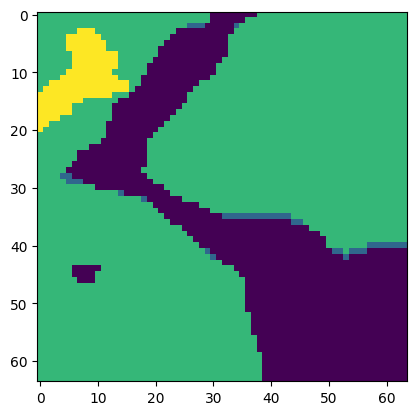

In [7]:
#@title Look at mask
plt.imshow(mask_patches[1,2,3,:,:,32])

In [8]:
#@title Convert input
#Convert grey image to 3 channels by copying channel 3 times because model expect 3 chanel input. 

input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

n_classes=4

train_img = np.stack((input_img,)*3, axis=-1)
train_img = train_img / 255. 
train_mask = np.expand_dims(input_mask, axis=4)


train_mask_cat = to_categorical(train_mask, num_classes=n_classes)


X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.10, random_state = 0)

##Train

In [20]:
#@title Anti-Disconnect for Colab
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>

In [29]:
#@title Train
history=model.fit(X_train, 
          y_train,
          batch_size=8, 
          epochs=130, #120
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/130
8/8 [==============================] - 33s 4s/step - loss: 0.6669 - dice_coefficient: 0.3464 - val_loss: 0.7761 - val_dice_coefficient: 0.2239
Epoch 2/130
8/8 [==============================] - 29s 4s/step - loss: 0.4567 - dice_coefficient: 0.5463 - val_loss: 0.7621 - val_dice_coefficient: 0.2379
Epoch 3/130
8/8 [==============================] - 28s 4s/step - loss: 0.3785 - dice_coefficient: 0.6220 - val_loss: 0.7031 - val_dice_coefficient: 0.2969
Epoch 4/130
8/8 [==============================] - 29s 4s/step - loss: 0.3412 - dice_coefficient: 0.6547 - val_loss: 0.6537 - val_dice_coefficient: 0.3463
Epoch 5/130
8/8 [==============================] - 29s 4s/step - loss: 0.3183 - dice_coefficient: 0.6780 - val_loss: 0.6172 - val_dice_coefficient: 0.3828
Epoch 6/130
8/8 [==============================] - 29s 4s/step - loss: 0.3021 - dice_coefficient: 0.6997 - val_loss: 0.5783 - val_dice_coefficient: 0.4217
Epoch 7/130
8/8 [==============================] - 29s 4s/step - loss:

In [48]:
#@title Save model
model.save('/content/drive/MyDrive/sandstone_data_for_ML/sandstone_3D_130epochs_dice.h5')

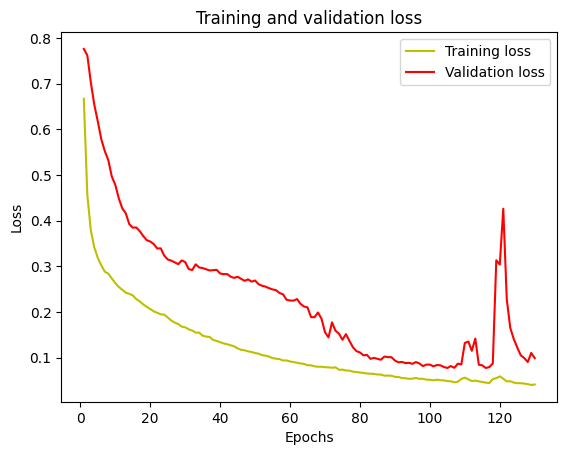

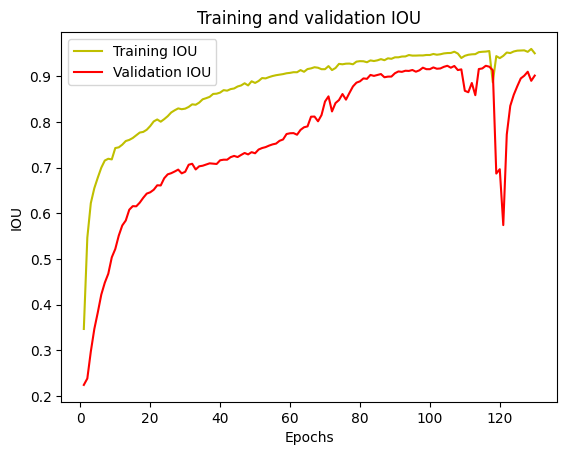

In [32]:
#@title Сharts
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coefficient']
val_acc = history.history['val_dice_coefficient']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

##Test

In [ ]:
#@title Load model
model = load_model('/content/drive/MyDrive/Colab Notebooks/sandstone_data_for_ML/sandstone_3D_130epochs_dice.h5', compile=False)

In [52]:
#@title Test
y_pred=model2.predict(X_test)
print(f'Test dice_coeff: {dice_coefficient(y_test, y_pred).numpy()}')

y_pred_argmax=np.argmax(y_pred, axis=4)
y_test_argmax = np.argmax(y_test, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 0s 43ms/step
Test dice_coeff: 0.9014077186584473
Mean IoU = 0.7480588


1/1 [==============================] - 0s 34ms/step


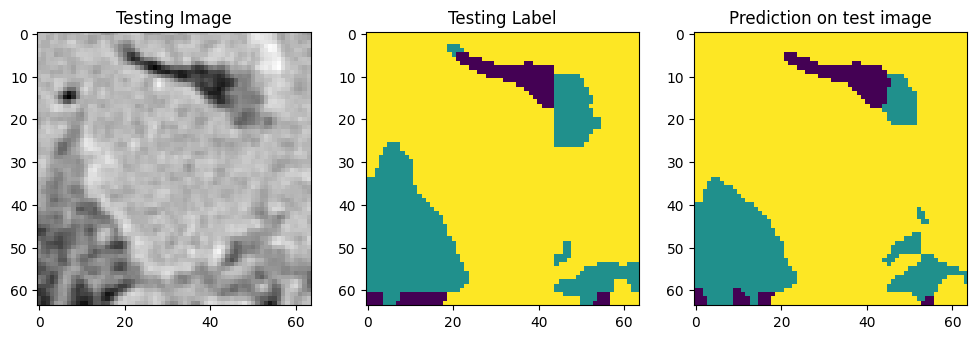

In [44]:
#@title Have a look at random test result
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)


test_pred = model.predict(test_img_input)
test_prediction = np.argmax(test_pred, axis=4)[0,:,:,:]

ground_truth_argmax = np.argmax(ground_truth, axis=3)

#Plot individual slices from test predictions for verification
slice = random.randint(0, ground_truth_argmax.shape[2]-1)
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction[slice,:,:])
plt.show()